In [ ]:
#Importing all the required Libraries
import torch,time,glob,os
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from torch import nn, optim


from skimage.color import rgb2lab, lab2rgb
from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#pip install fastai==2.4
from fastai.data.external import untar_data, URLs
#Downloading the COCO_SAMPLE Dataset
path_dataset = untar_data(URLs.COCO_SAMPLE)
path_dataset = str(path_dataset) + "/train_sample"

In [ ]:
path_Image = path_dataset
Image_path = glob.glob(path_Image + "/*.jpg")
#Setting the random seed to a fixed number
np.random.seed(123)
paths_subset = np.random.choice(Image_path, 10_000, replace=False)

#Seperating the COCO_DATASET into traning and validation parts with 80% as training and 20% as validation
dataset_random = np.random.permutation(10_000)
dataset_train = dataset_random[:8000]
paths_training = paths_subset[dataset_train]
dataset_validation = dataset_random[8000:]
paths_validation = paths_subset[dataset_validation]
print(len(paths_training), len(paths_validation))

8000 2000


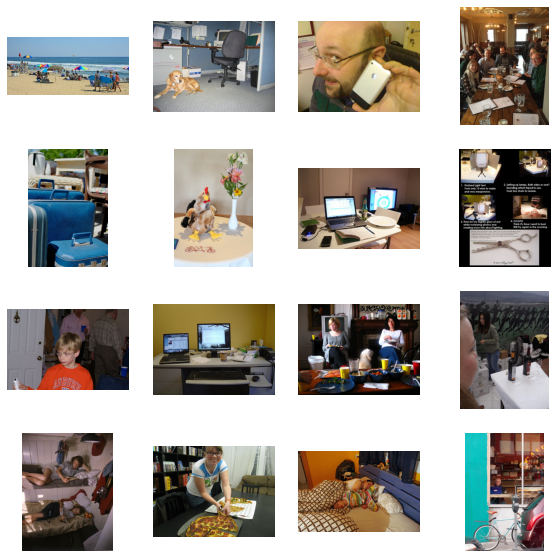

In [ ]:
#Plotting an image patch(which contains 16 images) as 4 rows and 4 columns
_, axis = plt.subplots(4, 4, figsize=(10, 10))
for axs, img_path in zip(axis.flatten(), paths_training):
    axs.imshow(Image.open(img_path))
    axs.axis("off")

In [ ]:
#Resizing the images to length and width as 256
LENGTH = 256
class Image_Colorization(Dataset):
    #Data Agumentation
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((LENGTH, LENGTH),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), 
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((LENGTH, LENGTH),  Image.BICUBIC)
        
        self.split = split
        self.size = LENGTH
        self.paths = paths
    
    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        image = self.transforms(image)
        image = np.array(image)
        lab_image = rgb2lab(image).astype("float32")
        lab_image = transforms.ToTensor()(lab_image)
        L = lab_image[[0], ...] / 50. - 1. 
        ab = lab_image[[1, 2], ...] / 110. 
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def dataloader_initiator(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = Image_Colorization(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
dataloader_train = dataloader_initiator(paths=paths_training, split='train')
dataloader_validation = dataloader_initiator(paths=paths_validation, split='val')

data = next(iter(dataloader_train))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(dataloader_train), len(dataset_validation))

In [ ]:
#Generator Block
class Generator_Patch_UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Generator_Patch_Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        block_unet = Generator_Patch_UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            block_unet = Generator_Patch_UnetBlock(num_filters * 8, num_filters * 8, submodule=block_unet, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            block_unet = Generator_Patch_UnetBlock(out_filters // 2, out_filters, submodule=block_unet)
            out_filters //= 2
        self.model = Generator_Patch_UnetBlock(output_c, out_filters, input_c=input_c, submodule=block_unet, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
#Discriminator 
class Discriminator_Patch(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] 
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
                                                                                             
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
discriminator = Discriminator_Patch(3)
dummy_input = torch.randn(16, 3, 256, 256) 
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def labels_getter(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.labels_getter(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def weights_initializer(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = weights_initializer(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Generator_Patch_Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(Discriminator_Patch(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class Loss_Logger:
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def __init__(self):
        self.reset()
    
    def value_updater(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = Loss_Logger()
    loss_D_real = Loss_Logger()
    loss_D = Loss_Logger()
    loss_G_GAN = Loss_Logger()
    loss_G_L1 = Loss_Logger()
    loss_G = Loss_Logger()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.value_updater(loss.item(), count=count)

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def Result_Visualizer(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/100
Iteration 200/500
loss_D_fake: 0.45881
loss_D_real: 0.48317
loss_D: 0.47099
loss_G_GAN: 1.59673
loss_G_L1: 9.33175
loss_G: 10.92848


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


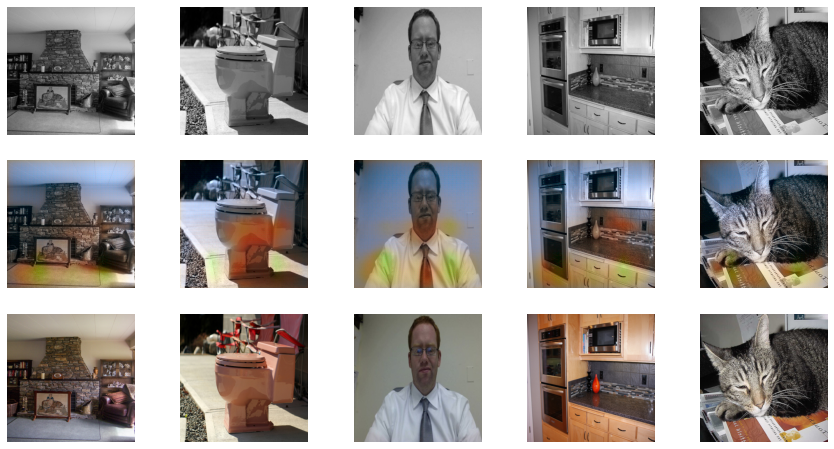


Epoch 1/100
Iteration 400/500
loss_D_fake: 0.46131
loss_D_real: 0.48711
loss_D: 0.47421
loss_G_GAN: 1.57577
loss_G_L1: 9.75117
loss_G: 11.32695


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


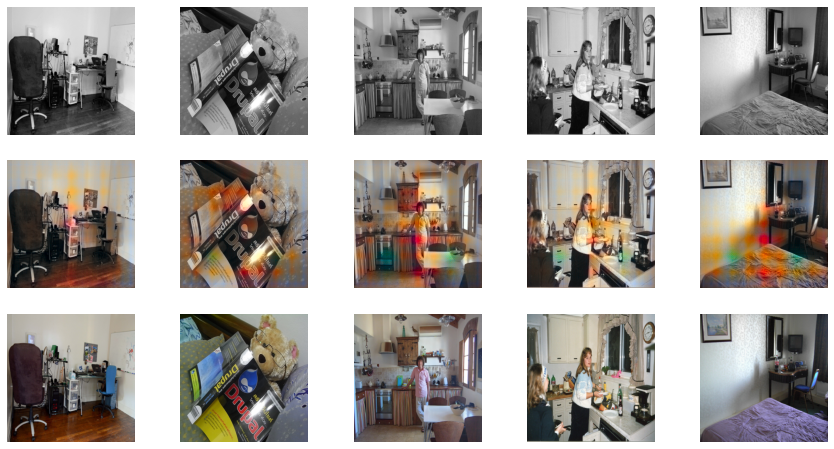

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def model_training(model,dataloader_train, epochs, Image_Display_Range=200):
    data = next(iter(dataloader_validation)) 
    for f in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(dataloader_train):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))
            i += 1
            if i % Image_Display_Range == 0:
                print(f"\nEpoch {f+1}/{epochs}")
                print(f"Iteration {i}/{len(dataloader_train)}")
                log_results(loss_meter_dict)
                Result_Visualizer(model, data, save=False)

model = MainModel()
model_training(model,dataloader_train, 100)